importing libraries

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter

# Set plotting style
sns.set_style('whitegrid')


## data loading and cleaning

In [12]:
import pandas as pd

# Load the dataset using the correct relative path
df = pd.read_csv('../data/raw/restaurant_reviews.csv')

# Select the necessary columns and drop rows with missing ratings
df = df[['Review','Rating']]
df = df.dropna(subset=["Rating", "Review"])

# Ensure ratings are digits and convert the column to integer type
df = df[df["Rating"].apply(lambda x: str(x).isdigit())]
df["Rating"] = df["Rating"].astype(int)

# Ensure the 'Review' column is always a string
df['Review'] = df['Review'].astype(str)

print("Data loaded and cleaned successfully.")
print(f"Shape of the dataframe: {df.shape}")
df.head()



Data loaded and cleaned successfully.
Shape of the dataframe: (9810, 2)


,Review,Rating
0,"The ambience was good, food was quite good . h...",5
1,Ambience is too good for a pleasant evening. S...,5
2,A must try.. great food great ambience. Thnx f...,5
3,Soumen das and Arun was a great guy. Only beca...,5
4,Food is good.we ordered Kodi drumsticks and ba...,5


MAP rating and setiment

In [13]:
def map_sentiment(rating):
    if rating > 3:
        return "positive"
    elif rating < 3:
        return "negative"
    else:
        return "neutral"

df["Sentiment"] = df["Rating"].apply(map_sentiment)

print("Sentiment column created.")
df.head()


Sentiment column created.


,Review,Rating,Sentiment
0,"The ambience was good, food was quite good . h...",5,positive
1,Ambience is too good for a pleasant evening. S...,5,positive
2,A must try.. great food great ambience. Thnx f...,5,positive
3,Soumen das and Arun was a great guy. Only beca...,5,positive
4,Food is good.we ordered Kodi drumsticks and ba...,5,positive


check class balances


C:\Users\krish\AppData\Local\Temp\ipykernel_17992\4068568349.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Sentiment", data=df, palette="coolwarm", order=['positive', 'negative', 'neutral'])


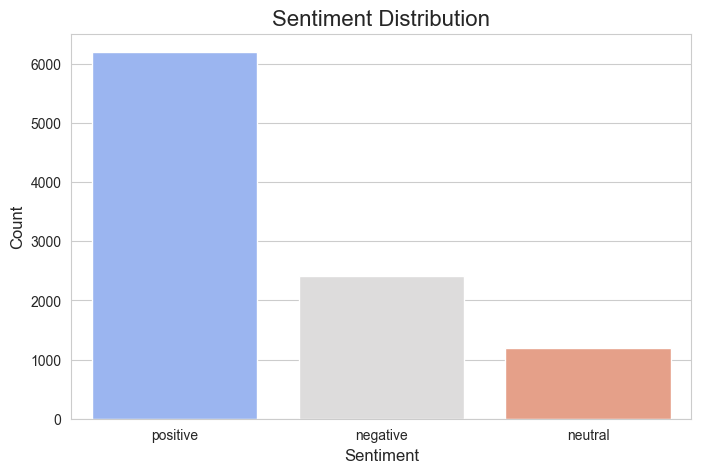

Sentiment Value Counts (Normalized):
Sentiment
positive    0.631906
negative    0.246585
neutral     0.121509
Name: proportion, dtype: float64


In [14]:
# Plot the sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x="Sentiment", data=df, palette="coolwarm", order=['positive', 'negative', 'neutral'])
plt.title("Sentiment Distribution", fontsize=16)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

# Display the exact value counts
print("Sentiment Value Counts (Normalized):")
print(df["Sentiment"].value_counts(normalize=True))


text cleaning function

In [15]:
# Download necessary NLTK data (only needs to be done once)
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    
    # Tokenize the text
    words = text.split()
    
    # Remove stopwords and lemmatize
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return " ".join(lemmatized_words)

print("Preprocessing function is ready.")


Preprocessing function is ready.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


preprocessing

In [16]:
# Apply the preprocessing function to the Review column
# This may take a moment to run
df['Processed_Review'] = df['Review'].apply(preprocess_text)

print("Text preprocessing complete. Here's a before-and-after example:")
print("\n--- ORIGINAL REVIEW ---")
print(df['Review'].iloc[0])
print("\n--- PROCESSED REVIEW ---")
print(df['Processed_Review'].iloc[0])


Text preprocessing complete. Here's a before-and-after example:

--- ORIGINAL REVIEW ---
The ambience was good, food was quite good . had Saturday lunch , which was cost effective .
Good place for a sate brunch. One can also chill with friends and or parents.
Waiter Soumen Das was really courteous and helpful.

--- PROCESSED REVIEW ---
ambience good food quite good saturday lunch cost effective good place sate brunch one also chill friend parent waiter soumen da really courteous helpful


TDF-IDF vectorization

In [17]:
# Initialize the TF-IDF Vectorizer
# max_features limits the vocabulary size to the top 5000 words
# ngram_range=(1,2) considers both single words and pairs of words (bigrams)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Create the feature matrix (X) and target vector (y)
X = tfidf.fit_transform(df['Processed_Review'])
y = df['Sentiment']

print("TF-IDF vectorization complete.")
print(f"Shape of the feature matrix (X): {X.shape}")


TF-IDF vectorization complete.
Shape of the feature matrix (X): (9810, 5000)


split data 

In [18]:
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, # for reproducibility
    stratify=y       # IMPORTANT for imbalanced data
)

print("Data splitting complete.")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Data splitting complete.
Training data shape: (7848, 5000)
Testing data shape: (1962, 5000)


Apply SMOTE for Resampling

In [19]:
print(f"Original training set distribution: {Counter(y_train)}")

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and apply SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled training set distribution: {Counter(y_train_resampled)}")


Original training set distribution: Counter({'positive': 4959, 'negative': 1935, 'neutral': 954})
Resampled training set distribution: Counter({'negative': 4959, 'positive': 4959, 'neutral': 4959})


Train the Model

In [20]:
# Initialize the Logistic Regression model
# We increase max_iter to ensure convergence
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model on the resampled training data
model.fit(X_train_resampled, y_train_resampled)

print("Model training complete.")


Model training complete.


model eval 

Model Accuracy: 0.7880

Classification Report:

              precision    recall  f1-score   support

    negative       0.79      0.79      0.79       484
     neutral       0.35      0.47      0.40       238
    positive       0.91      0.85      0.88      1240

    accuracy                           0.79      1962
   macro avg       0.68      0.70      0.69      1962
weighted avg       0.81      0.79      0.80      1962


Confusion Matrix:



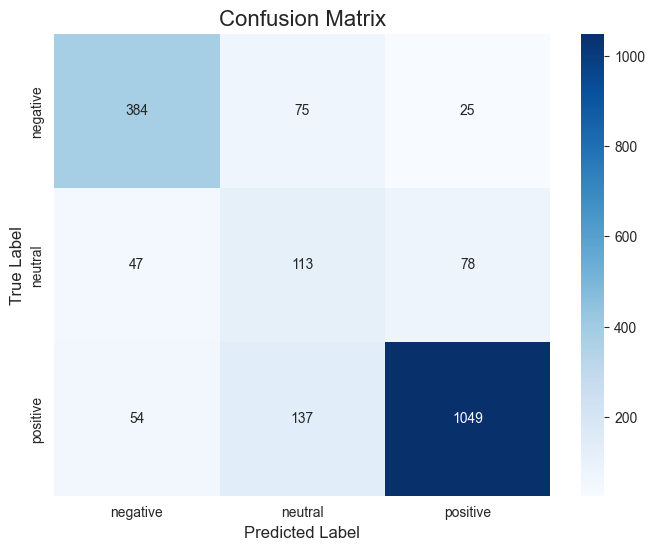

In [21]:
# Make predictions on the original test set
y_pred = model.predict(X_test)

# Print the accuracy
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")

# Print the detailed classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Visualize the confusion matrix
print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()
